# Gaussian Process Regression

## Introduction

## I. Gaussian Process Regression

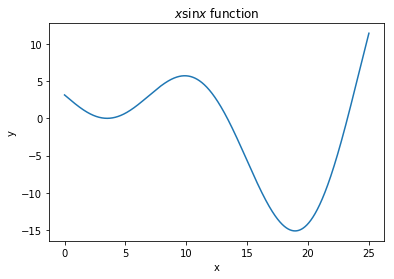

In [224]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)
#y_gpr , y_std = gpr.predict(X_plot , return_std=True)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [225]:
def cov_function(point_1,point_2,theta,sig):
    theta = np.asarray(theta)
    size = point_1.shape
    dist = (point_1-point_2)**2
    k_12 = (sig**2) * np.exp(- np.sum(dist / theta**2))
    return k_12

def cov_matrix(points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.zeros((size[0],size[0]))
    for i,point in enumerate(points):
        K[:,i] = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

def cov_vect(point,points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

### Question 1:

1.1 Code the function that predict the mean and the standard deviation of the Gaussian process

In [226]:
def myGPpredict(x_new, x_data, y_data, K_inv, theta, sig):
    # Code Here
    K_et = cov_vect(x_new,x_data,theta,sig)
    mu = K_et.dot(K_inv.dot(y_data))
    k_xx = cov_function(x_new,x_new,theta,sig)
    sigma = k_xx - K_et.dot(K_inv.dot(K_et.T))
    return mu[0],sigma

1.2 Test several values of $\theta = [l, \sigma_f]$ with  $l$ defined as the length-scale  (of oscillations) and  $\sigma_f$ the amplitude. Draw the different kriging regression on the same plot

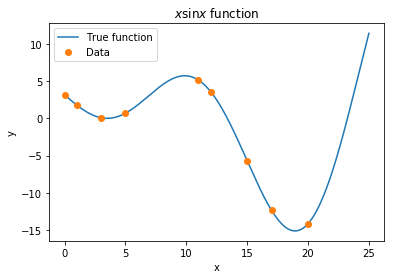

In [227]:
from sklearn.metrics import mean_squared_error, r2_score

x_test = np.atleast_2d(np.linspace(0,25,100)).T
y_test = fun(x_test)

x_data = np.atleast_2d([0,11,20,1,5,15,12,3,17]).T
y_data = fun(x_data)


X_plot = np.atleast_2d(np.linspace(0,25,1000)).T
Y_plot = fun(X_plot)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
lines.append(true_fun)
lines.append(data)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data'])
plt.show()

RMSE = 5.75745
R2 = 0.88390


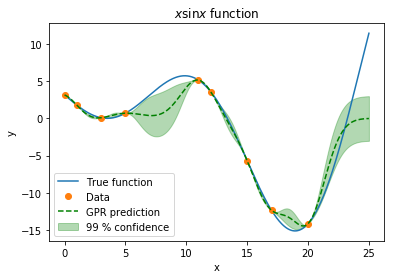

In [228]:
theta = [2]
sig = 1

K = cov_matrix(x_data,theta,sig)
K_inv = np.linalg.inv(K)

y_pred = np.array([myGPpredict(x_t,x_data,y_data,K_inv,theta,sig) \
                   for x_t in x_test])

RMSE = mean_squared_error(y_test,y_pred[:,0])
R2 = r2_score(y_test,y_pred[:,0])
print('RMSE = %.5f' %(RMSE)) 
print('R2 = %.5f' %(R2))

Y_GP_plot = np.array([myGPpredict(x_t,x_data,y_data,K_inv,theta,sig) \
                   for x_t in X_plot])
lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(X_plot.T[0],Y_GP_plot[:,0]+3*Y_GP_plot[:,1],Y_GP_plot[:,0]-3*Y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

1.3 Conclude: Is there a way to find $\theta_{optimal} = \theta*$

Answer : 

## II. Hyperparameters Optimization

### Question 2:

2.1 Make a 1D graph of the Marginal Likelyhood function of $l \in [10^{-3},1.25]$ at $\sigma_f$ fixed

Text(0.5,1,'Log Likelihood regarding theta')

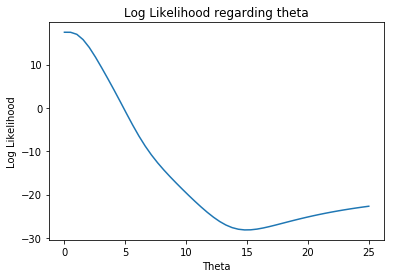

In [229]:
def likelihood(x_data,y_data,theta,sig):
    K = cov_matrix(x_data,theta,sig)
    args1 = y_data.T.dot(np.linalg.inv(K))
    args2 = np.log(args1.dot(y_data)/x_data.shape[0])
    args3 =  np.log(np.linalg.det(K))
    like = 0.5*(x_data.shape[0])*args2 + args3
    return like[0,0]

theta = np.linspace(1e-3,25)

like = np.array([likelihood(x_data,y_data,th,sig) for th in theta])

fig = plt.figure()
ax = fig.add_subplot(111)
line = ax.plot(theta,like)
ax.set_xlabel('Theta')
ax.set_ylabel('Log Likelihood')
ax.set_title('Log Likelihood regarding theta')

2.2 Optimize the Marginal Likelihood function to find $l^*$. Pay attention: some optimizers are gradient based and converged to a local optimum.

In [230]:
from scipy.optimize import minimize 

like_obj = lambda theta : likelihood(x_data,y_data,theta,sig)

# Multistart to remove bad optimization results
theta_start = np.linspace(1e-6,25,5)

opt_all = np.array([minimize(like_obj, th, method='SLSQP', bounds=[(1e-6,25)]) for th in theta_start])
opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
ind_min = np.argmin(obj_success)

opt = opt_success[ind_min]
theta_et = opt['x']

print('Optimization results', opt)
print('')
print('Best theta is %.5f' %(theta_et))

Optimization results      fun: -28.165631736262398
     jac: array([-3.11556625])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([15.20476652])

Best theta is 15.20477


## III. Optimization

## Question 3

3.1 Build the GP model with a square exponential kernel with scikit-learn toolbox knowing $(x_{data}, y_{data})$.

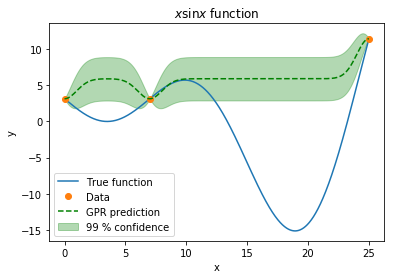

In [231]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF as SEkernel

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

ker = SEkernel()
gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)

gpr.fit(x_data,y_data)

Y_GP_plot = gpr.predict(X_plot,return_std=True)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

## Question 4

4.1 Give at least 2 methods to optimize the true function thanks to Gaussian Process. You don't have to code it explicitly, give the main idea.

Answer: 

## Question 5

5.1 Code the Efficient Global optimization

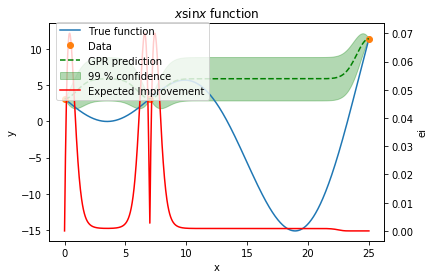

In [232]:
from scipy.stats import norm
 
def EI(GP,points,f_min):
    pred = GP.predict(points,return_std=True)
    args0 = (f_min - pred[0])/np.atleast_2d(pred[1]).T
    args1 = (f_min - pred[0])*norm.cdf(args0)
    args2 = np.atleast_2d(pred[1]).T*norm.pdf(args0)
    ei = args1 + args2
    return ei


Y_GP_plot = gpr.predict(X_plot,return_std=True)
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

5.2 Complete the code the EGO method and compare it to a standart Surrogate based optimization approach

In [276]:
def SBO(GP,point):
    return GP.predict(point)

plt.ion()

x_data = np.atleast_2d([1,10,25]).T
y_data = fun(x_data)

n_iter = 7
ker = SEkernel()
gpr = gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)

for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(15)*25).T
    f_min_k = np.min(y_data)
    gpr.fit(x_data,y_data)
    obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)
    # obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(obj_k, x_st, method='L-BFGS-B', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
    Y_GP_plot = gpr.predict(X_plot,return_std=True)
    Y_EI_plot = EI(gpr,X_plot,np.min(y_data))    
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print('Results : X %s, Y %s' %(x_opt,y_opt))

Results : X [17.74147234], Y [-14.0134496]
